##  Digital Quantum Simulations of Time Evolution - Simulating the Dicke Model
---
### Modules and some comments
Take a look at the file `classical_evolution` in the folder `tools`.

In [304]:
# Ignore: things to make plots pretty on my computer 
from pkg_resources import working_set

if 'jupyterthemes' in ["%s" % package.key for package in working_set]:
    from jupyterthemes import jtplot
    jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = True)

In [305]:
# Important: the functions below are defined in the files `classical_evolution` and 
# `quantum_evolution` in the folder `tools`
from tools.classical_evolution import dicke_hamiltonian, state_probability, define_state
from tools.quantum_evolution import get_circuit, trotter_circuit, define_operator

In [306]:
# Usual suspects
from numpy import linspace, pi, zeros_like, zeros, ones
from qiskit import Aer
from qiskit.opflow import CircuitSampler, StateFn, I, Z
from qiskit.opflow.expectations import PauliExpectation
from matplotlib.pyplot import plot, xlabel, ylabel, title, grid, show, legend, ylim

### Classical simulation
It is already generalizable to $N>2$ and, hoping that it is more or less correct, you can already try to see what happens by changing the `spins` variable.

In [318]:
# Checking if the hamiltonian is correct
spins = 2 # Number of 2-level systems
coupling = 1
frequency = 1
hamiltonian = dicke_hamiltonian(spins = spins, frequency = frequency, coupling = coupling)
print(hamiltonian)

1.0 * IZ
+ 1.0 * ZI
- 2.0 * XX


In [319]:
# Classical simulation
times = linspace(0, pi, 200) # Time discretization
initial_state = define_state([0 for _ in range(spins)]) # Ground state: all spins down
state = define_state([1 for _ in range(spins)]) # All spins up
classical_probabilities = [state_probability(hamiltonian, time, initial_state, state) for time in times]

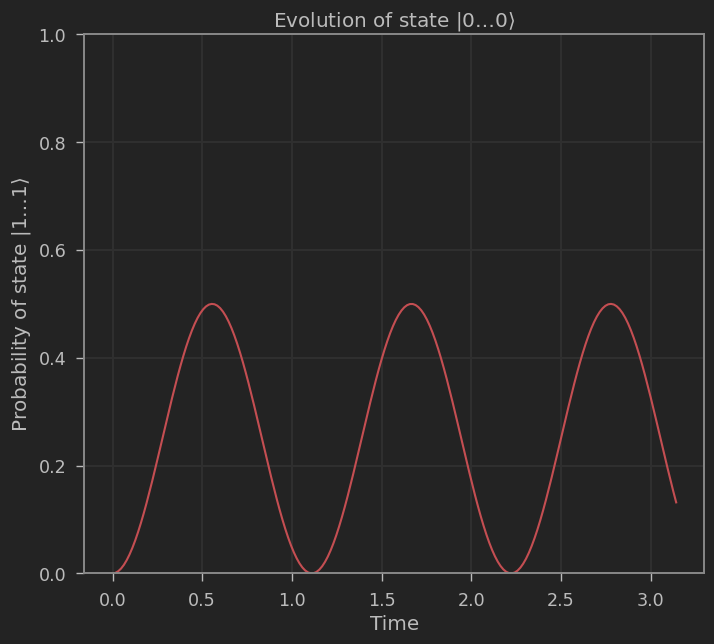

In [320]:
plot(times, classical_probabilities, '-r')
xlabel('Time')
ylim(0, 1)
ylabel(r'Probability of state $|1\dots1\rangle$')
title(r'Evolution of state $|0\dots0\rangle$')
show()

### Quantum simulation
First notice that:

$$H^{(2)}=\omega_z\left(\sigma_z^{(1)}+\sigma_z^{(2)}\right)-2g\sigma_x^{(1)}\sigma_x^{(2)}$$

now, we have that:

$$
\begin{cases}
\left[\sigma_z^{(1)}, \sigma_z^{(1)}\right]=0 \\
\left[\sigma_z^{(1)}, \sigma_x^{(1)}\sigma_x^{(2)}\right]=\left[\sigma_z^{(1)}, \sigma_x^{(1)}\right]\sigma_x^{(2)}=-2\mathcal{i}\sigma_y^{(1)}\sigma_x^{(2)} \\
\left[\sigma_z^{(2)}, \sigma_x^{(1)}\sigma_x^{(2)}\right]=\dots=-2\mathcal{i}\sigma_y^{(2)}\sigma_x^{(1)} \\
\end{cases}
$$

thus they do not commute even in this case, so we have to use the Trotter-Suzuki technique.

By the way, it should work with whatever number $N$, also for $N>2$.

**Question**: why we use the same $n$ for all the time instants in the implementation of the Trotter-Suzuki technique?

In [321]:
backend = Aer.get_backend("statevector_simulator")
expectation = PauliExpectation() 
sampler = CircuitSampler(backend)

In [322]:
steps = [4, 8, 12]
quantum_probabilities = {i : zeros_like(times) for i in steps}
operator = define_operator([1 for _ in range(spins)])

In [323]:
for steps in quantum_probabilities.keys():
    for i, time in enumerate(times):
        circuit = trotter_circuit(spins, time, steps, coupling)
        trotter_expectation = expectation.convert(operator @ StateFn(circuit))
        trotter_sample = sampler.convert(trotter_expectation)
        quantum_probabilities[steps][i] = trotter_sample.eval().real

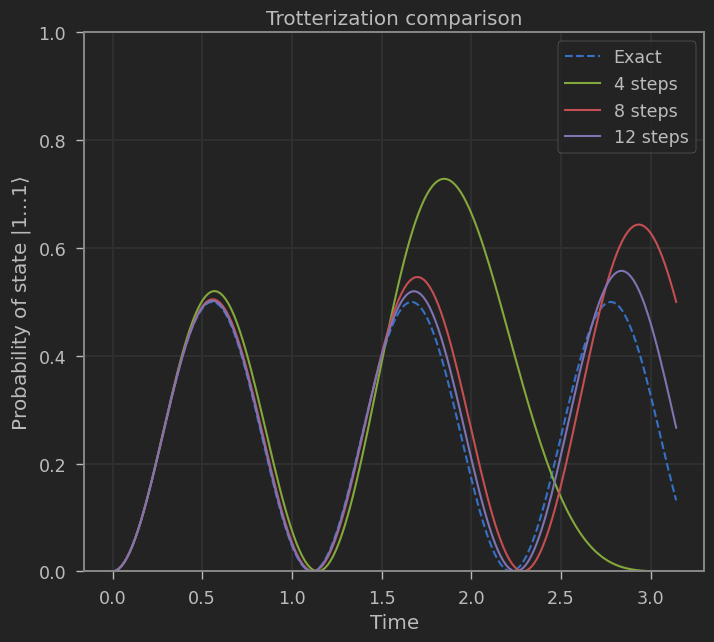

In [328]:
plot(times, classical_probabilities, '--', label = "Exact")

for steps in quantum_probabilities.keys():
    plot(times, quantum_probabilities[steps], label = str(steps) + " steps")

xlabel('Time')
ylabel(r'Probability of state $|1\dots1\rangle$')
title(r'Trotterization comparison')
ylim(0, 1)
legend()
show()

# Computing magnetization

In [360]:
from numpy import array, kron, abs, real
from scipy.linalg import expm

In [361]:
# Classical simulation of the Heisenberg dimer model
ctime = linspace(0, pi, 1000)

# Preparation of physical quantity: writing the single qubit operators, that is the Pauli matrices
i = array([[1, 0], [0, 1]], dtype = complex) 
x = array([[0, 1], [1, 0]], dtype = complex) 
z = array([[1, 0], [0, -1]], dtype = complex) 

# Writing the two qubit operators
za = kron(z, i)
zb = kron(i, z)

# Initial state definition and execution
zero = array([1, 0], dtype = complex)
one = array([0, 1], dtype = complex)
psio = kron(zero, zero) # Initial state
coupling = 1
H = frequency * (za + zb) - 2 * coupling * kron(x, x) # Hamiltonian

# Data structures to contain the measures
zac = zeros_like(ctime)
zbc = zeros_like(ctime)

for i, t in enumerate(ctime):
    psit = expm(-1j * H * t) @ psio
    zac[i] = real(psit.conjugate().transpose() @ za @ psit) / 2
    zbc[i] = real(psit.conjugate().transpose() @ zb @ psit) / 2

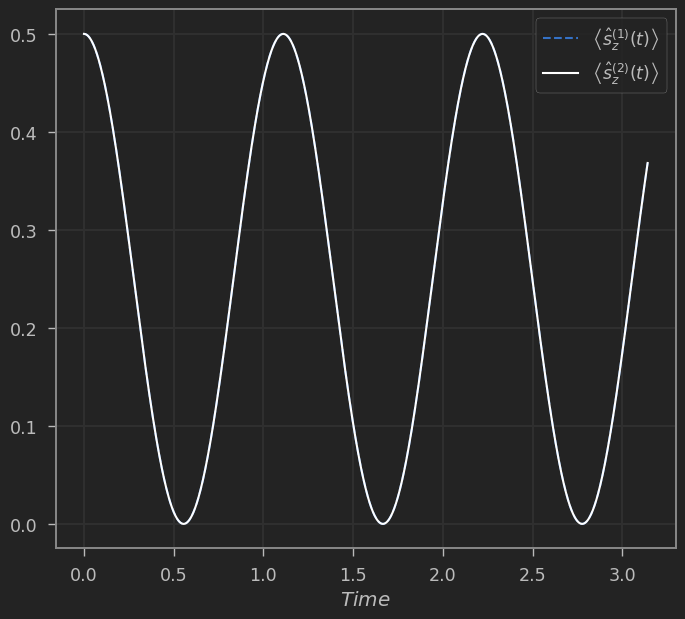

In [362]:
plot(ctime, zac, 'b--')
plot(ctime, zbc, 'w-')
legend([r'$\left\langle\hat{s}^{(1)}_z(t)\right\rangle$',
        r'$\left\langle\hat{s}^{(2)}_z(t)\right\rangle$'])
xlabel(r'$Time$')
show()

In [363]:
from qiskit import BasicAer, transpile, execute
from qiskit.circuit import Parameter
from qiskit.providers.aer import QasmSimulator

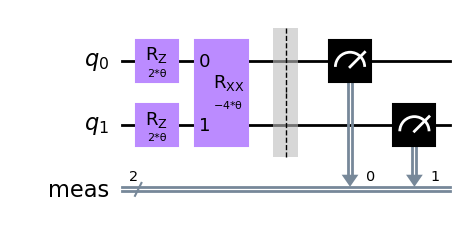

In [364]:
# Creating the parametrized circuit
qtime = linspace(0, pi, 50)
theta = Parameter('θ')
spins = 2
circuit = QuantumCircuit(2)
circuit.rz(2 * theta, 0)
circuit.rz(2 * theta, 1)
circuit.rxx(-4 * coupling * theta, 0, 1)
circuit.measure_all()
circuit.draw('mpl')

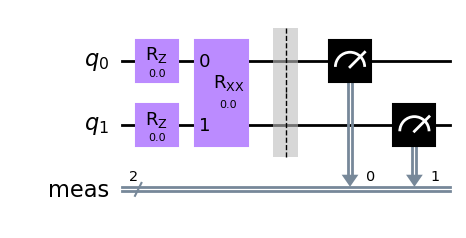

In [365]:
times = linspace(0, pi, 50)
shots = 1000
circuits = [circuit.bind_parameters({theta: time}) for time in qtime]
circuits[0].draw('mpl')

In [369]:
# Transpiling and simulating
backend = BasicAer.get_backend('qasm_simulator')
transpiled_circuits = transpile(circuits, backend)
job = backend.run(transpiled_circuits, shots = shots)
counts = job.result().get_counts()

In [370]:
%%time
zaq, zbq = zeros_like(qtime), zeros_like(qtime)

for i, count in enumerate(counts):
    a = b = count.get('00', 0) - count.get('11', 0)
    a += count.get('10', 0) - count.get('01', 0)
    b -= count.get('10', 0) - count.get('01', 0)
    
    zaq[i] = a / shots / 2
    zbq[i] = b / shots / 2

CPU times: user 207 µs, sys: 16 µs, total: 223 µs
Wall time: 223 µs


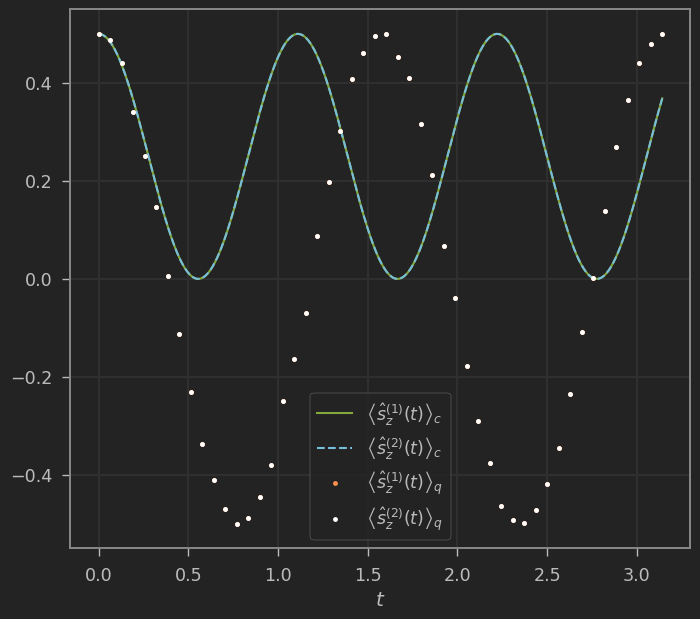

In [371]:
plot(ctime, zac, 'g-')
plot(ctime, zbc, 'c--')
plot(qtime, zaq, 'y.')
plot(qtime, zbq, 'w.')
legend([r'$\left\langle\hat{s}^{(1)}_z(t)\right\rangle_c$',
        r'$\left\langle\hat{s}^{(2)}_z(t)\right\rangle_c$',
        r'$\left\langle\hat{s}^{(1)}_z(t)\right\rangle_q$',
        r'$\left\langle\hat{s}^{(2)}_z(t)\right\rangle_q$'])
xlabel(r'$t$')
show()